<a href="https://colab.research.google.com/github/wadaka0821/nlp-tutorial/blob/main/questions/5_5_nural_language_model_question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ニューラル言語モデル
## 作成者：和田
## 最終更新日：2023/03/09

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
from datasets import load_dataset
from tqdm import tqdm
import torch
from torch.nn import Embedding, LSTM, Linear, Softmax, CrossEntropyLoss
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
import numpy as np
import seaborn as sns

In [ ]:
nltk.download('punkt') # 単語分割に必要なデータのダウンロード

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
dataset = load_dataset("common_gen") # 使用するデータのダウンロード

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
corpus = dataset['train']['target']

In [ ]:
tokenized_corpus = list(map(nltk.tokenize.word_tokenize, corpus))

In [ ]:
class LM(torch.nn.Module):
    PAD_TOKEN = '<PAD>' # Padding 用
    SOS_TOKEN = '<s>' # Start Of Sequence
    EOS_TOKEN = '</s>' # End Of Sequence
    UNK_TOKEN = '<UNK>' # 未知語

    def __init__(self, corpus, hidden_dim=200):
        super(LM, self).__init__()
        self.vocab = {self.PAD_TOKEN:0,
                      self.SOS_TOKEN:1,
                      self.EOS_TOKEN:2,
                      self.UNK_TOKEN:3}
        self.vocab_size = len(self.vocab)
        self.corpus = corpus
        self.hidden_dim = hidden_dim
        self._build_vocab()
        self.embedding = Embedding(
            num_embeddings = self.vocab_size,
            embedding_dim = self.hidden_dim,
        )
        self.lstm = LSTM(
            input_size = self.hidden_dim,
            hidden_size = self.hidden_dim,
            bias = True,
            batch_first = True,
            bidirectional = False,
        )
        self.output_linear = Linear(
            in_features = self.hidden_dim,
            out_features = self.vocab_size,
        )
    
    def _build_vocab(self):
        for sent in self.corpus:
            for word in sent:
                if word not in self.vocab:
                    self.vocab[word] = len(self.vocab)
        self.vocab_size = len(self.vocab)

    def encode(self, sent):
        if type(sent[0]) == type(list()):
            return [[self.vocab.get(j) if self.vocab.get(j) else self.vocab[self.UNK_TOKEN] for j in i] for i in sent]
        else:
            return [self.vocab.get(i) if self.vocab.get(i) else self.vocab[self.UNK_TOKEN] for i in sent]

    def decode(self, ids):
        vocab_rev = {value:key for key, value in self.vocab.items()}
        if type(ids[0]) == type(list()):
            return [[vocab_rev.get(j) for j in i] for i in ids]
        else:
            return [vocab_rev.get(i) for i in ids]

    def forward(self, X, device='cpu'):
        X = self.embedding(X)
        h = torch.zeros(1, len(X), self.hidden_dim).to(device)
        c = torch.zeros(1, len(X), self.hidden_dim).to(device)
        o, _ = self.lstm(X, (h, c))
        o = self.output_linear(o)

        return o

    @torch.inference_mode()
    def predict(self, X, device='cpu', max_length=64):
        generated_ids = X.tolist()
        h = torch.zeros(1, self.hidden_dim).to(device)
        c = torch.zeros(1, self.hidden_dim).to(device)

        while generated_ids[-1] != self.vocab[self.EOS_TOKEN] and len(generated_ids) < max_length:
            lstm_input = self.embedding(torch.Tensor(generated_ids).long().to(device))
            o, _ = self.lstm(lstm_input, (h, c))
            o = self.output_linear(o)
            idx = torch.argmax(o[-1])
            generated_ids.append(idx.item())
        
        return generated_ids

In [ ]:
model = LM(tokenized_corpus)

In [ ]:
corpus_ids = model.encode([[LM.SOS_TOKEN]+sent+[LM.EOS_TOKEN] for sent in tokenized_corpus])

In [ ]:
X = [torch.Tensor(i[:-1]).long() for i in corpus_ids]
Y = [torch.Tensor(i[1:]).long() for i in corpus_ids]

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
train_dataset = MyDataset(X, Y)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: [[i[0] for i in x], [i[1] for i in x]])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)
MAX_EPOCH = 10

model.to(device)

loss_history = list()
for epoch in range(1, MAX_EPOCH+1):
    for X, Y in tqdm(dataloader):
        optimizer.zero_grad(set_to_none=True)
        X = pad_sequence(X, batch_first=True).to(device)
        Y = pad_sequence(Y, batch_first=True).to(device)

        o = model(X, device)
        o = o.view(o.shape[0]*o.shape[1], -1) # CrossEntropyLoss の入力用に shape を変更
        Y = Y.view(-1)
        loss = criterion(o, Y)

        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()
    mean_loss = np.mean(loss_history[-len(dataloader):])
    print(f'{epoch=} | {mean_loss=} |')

100%|██████████| 2106/2106 [00:19<00:00, 109.34it/s]


epoch=1 | mean_loss=3.235457199477968 |


100%|██████████| 2106/2106 [00:19<00:00, 110.80it/s]


epoch=2 | mean_loss=2.637579584166988 |


100%|██████████| 2106/2106 [00:19<00:00, 105.71it/s]


epoch=3 | mean_loss=2.3679026973213566 |


100%|██████████| 2106/2106 [00:19<00:00, 108.58it/s]


epoch=4 | mean_loss=2.1882455158777048 |


100%|██████████| 2106/2106 [00:19<00:00, 109.57it/s]


epoch=5 | mean_loss=2.0500173302117917 |


100%|██████████| 2106/2106 [00:19<00:00, 109.85it/s]


epoch=6 | mean_loss=1.9340738683005003 |


100%|██████████| 2106/2106 [00:19<00:00, 109.17it/s]


epoch=7 | mean_loss=1.8375209028791046 |


100%|██████████| 2106/2106 [00:19<00:00, 108.80it/s]


epoch=8 | mean_loss=1.7538045133620586 |


100%|██████████| 2106/2106 [00:19<00:00, 109.26it/s]


epoch=9 | mean_loss=1.6808507830215882 |


100%|██████████| 2106/2106 [00:19<00:00, 108.96it/s]

epoch=10 | mean_loss=1.6207784620898176 |


[Text(0.5, 1.0, 'training loss'),
 Text(0.5, 0, 'step'),
 Text(0, 0.5, 'CrossEntropyLoss')]

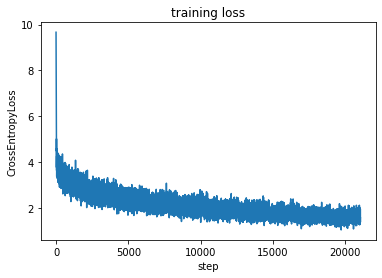

In [ ]:
p = sns.lineplot(x=[i+1 for i in range(len(loss_history))], y=loss_history)
p.set(
    title = 'training loss',
    xlabel = 'step',
    ylabel = 'CrossEntropyLoss'
)

In [ ]:
pred_ids = model.predict(torch.Tensor([1]).long().to(device), device)

In [ ]:
model.decode(pred_ids)

['<s>',
 'A',
 'man',
 'is',
 'working',
 'on',
 'a',
 'shelf',
 'with',
 'a',
 'horse',
 'in',
 'a',
 'sunny',
 'day',
 '.',
 '</s>']

In [ ]:
text = ['<s>', 'The', 'sun']
encoded_text = model.encode(text)
print(encoded_text)
pred_ids = model.predict(torch.Tensor(encoded_text).long().to(device), device)
print(model.decode(pred_ids))

[1, 20, 827]
['<s>', 'The', 'sun', 'is', 'obscured', 'by', 'the', 'sea', '.', '</s>']


In [ ]:
text = ['<s>', 'The', 'rider']
encoded_text = model.encode(text)
print(encoded_text)
pred_ids = model.predict(torch.Tensor(encoded_text).long().to(device), device)
print(model.decode(pred_ids))

[1, 20, 1928]
['<s>', 'The', 'rider', 'is', 'winning', 'the', 'race', '.', '</s>']


In [ ]:
text = ['<s>', 'A', 'horse']
encoded_text = model.encode(text)
print(encoded_text)
pred_ids = model.predict(torch.Tensor(encoded_text).long().to(device), device)
print(model.decode(pred_ids))

[1, 9, 48]
['<s>', 'A', 'horse', 'is', 'eating', 'grass', 'in', 'a', 'zoo', '.', '</s>']


# 問題1
---
一般的に，LSTM は RNN と比べて長い系列が得意だとされています．今回学習されたモデルは LSTM を使用していますが，どの程度の長さまでまともな文が出力されるでしょうか？いろいろ試してみてください．

## 問題2
---
推論時に，確率の高い上位 k 件からランダムに選択するように predict を変更してください．